# 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

p538(557)~

In [18]:
import warnings
warnings.filterwarnings('ignore')

<br>

## 10.1 대회 소개

- Mercari Price Suggestion Challenge는 캐글에서 진행된 Challenge
- 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성
- Mercari사는 이러한 데이터를 기반으로 제품 예상 가격을 판매자들에게 제공하고자 한다.
- 이와 같은 프로세스를 구현하기 위해 판매자는 제품명, 브랜드명, 카테고리, 제품 설명 등 다양한 속성 정보를 입력
- ML 모델은 이 속성에 따라 제품의 예측 가격을 판매자에게 자동으로 제공할 수 있다.

<br>

### 10.1.1 데이터 세트 다운로드

- [다운로드 링크](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)

<br>

### 10.1.2 데이터 세트 속성

- `train_id` : 데이터 ID
- `name` : 제품명
- `item_condition_id` : 판매자가 제공하는 제품 상태
- `category_name` : 카테고리명
- `brand_name` : 브랜드 이름
- `price` : 제품 가격, 예측을 위한 **타깃 속성**
- `shipping` : 배송비 모류 여부
  - `1` : 무료 (판매자가 지불)
  - `0` : 유로 (구매자가 지불)
- `item_description` : 제품에 대한 설명

- `price`가 예측해야 할 타깃 값이다.
- 회귀로 피처를 학습한 뒤 `price`를 예측하는 문제
- Mercari Price Suggestion이 기존 회귀 예제와 다른 점은 `item_description`과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 휘귀를 수행한다는 점이다.

<br>

## 10.2 데이터 전처리

### 10.2.1 데이터셋 로드

- 필요한 라이브러리와 `mercari_train.tsv` 데이터를 DataFrame으로 로딩
- 데이터를 간략하게 확인

In [19]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('./data/Mercari/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


- 1482535개의 레코드를 가지고 있는 데이터 세트

<br>

### 10.2.2 피처 타입 및 Nul 여부 확인

In [20]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


<br>

**`brand_name`**

- `brand_name` 컬럼의 경우 매우 많은 Null값을 가지고 있음
  - 전체 1482535건 중에 849853건만 Not null이다.
- `brand_name`은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어 있다.

<br>

**`category_name`**

- `category_name`은 약 6300건의 null 데이터를 가지고 있음

<br>

**`item_description`**

- `item_description`의 null값은 4건으로 미비하다.

<br>

이 Null 데이터는 이후에 적절한 문자열로 치환

<br>

### 10.2.3 Target 컬럼 분포 확인

- Target 값인 `price` 컬럼의 데이터 분포도 확인
- 회귀에서 Target 값의 정규 분포도는 매우 중요하다.
- 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가지게 된다.

- `price` 컬럼의 데이터 값 분포도 확인

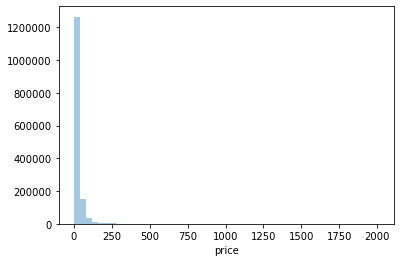

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)
plt.show()

- `price` 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포돼 있다.

<br>

### 10.2.4 타깃 컬럼 로그 변환

- `Price` 컬럼을 로그 값으로 변환한 뒤 분포도 다시 확인

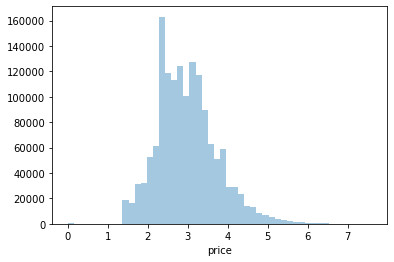

In [22]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)
plt.show()

- 로그 값으로 변환하면 `price` 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다.
- 데이터 세트의 `price` 컬럼을 원래 값에서 로그로 변환된 값으로 변경

In [23]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

<br>

### 10.2.5 피처 분포 확인

- 다른 피처의 값도 확인

<br>

#### 10.2.5.1 `shipping`

In [24]:
mercari_df['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

- `Shipping` 컬럼은 **배송비 유무**
- 값이 비교적 균일하다.

<br>

#### 10.2.5.2 `item_condition_id`

In [25]:
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

- `Item_condition_id`는 **판매자가 제공하는 제품 상태**
- 각 값이 의미하는 바는 캐글에 기재돼 있지 않아서 알 수 없지만, 1,2,3 값이 주를 이루고 있음

<br>

#### 10.2.5.3 `item_description`

- `item_description` 컬럼은 Null 값은 별로 없음
- description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있다.
- 이러한 값이 얼마나 있는 지 확인

In [26]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- `item_description`이 'No description yet`으로 돼 있는 행은 82489건이다.
- 'No description yet'의 경우도 Null과 마찬가지로 의미 있는 속성값으로 사용될 수 없으므로 적절한 값으로 변경해야 한다.

<br>

#### 10.2.5.4 `category_name`

- `category_name`은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다.
  - ex) 'Men/Tops/T-shirts'
    - 대분류 : 'Men'
    - 중분류 : 'Tops'
    - 소분류 : 'T-shirts'
- `category_name`은 텍스트이므로 피처 추출 시 `tokenizer`를 '/'로 하여 단어를 분리해 벡터화할 수 도 있음
- 여기서는 `category_name`의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습

- `category_name` 컬럼을 '/'를 기준으로 대, 중, 소분류로 효과적으로 분리해 내기 위해 별도의 `split_cat()` 함수를 생성
- 이 함수를 DataFrame의 `apply lambda` 식에 적용

- `category_name` 컬럼은 Null값을 약 6300여 건을 가지고 있으므로 이에 유의하면서 분리해야 한다.

In [27]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성
# 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        # category_name이 Null일 경우에는 split() 함수가 Error를 발생하므로 예외 처리
        return ['Other_Null','Other_Null','Other_Null']

<br>